In [1]:
# plot S2 occupancy results
import MDAnalysis as mda
from MDAnalysis.analysis import align
import os

import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
from tqdm import tqdm

fontsize = 30
plt.rc('font', size=fontsize)
plt.rc('axes', titlesize=fontsize)
plt.rc('axes', labelsize=fontsize) 
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rc('legend', fontsize=fontsize)
plt.rcParams["font.family"] = "TeX Gyre Heros"



/home/xlf/Apps/anaconda3/envs/xlf/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
path = '/mnt/sdb/xlf/Desktop/ion_channels/TRPV6/oriSystem/150mMCa_trjs'


os.chdir(path)

top_dire = 'md1_ion_prot.gro'
trj_dire = 'md3_ion_prot.xtc'

trj_dires = ['md'+str(x)+'_ion_prot.xtc' for x in range(1,4)]

u = mda.Universe(top_dire,trj_dires)
u.transfer_to_memory(verbose=True) 

Nt = len(u.trajectory)  # number of frames
t_total = u.trajectory[-1].time/1000.0 # unit: ns
t_frame = u.trajectory[1].time/1000.0 
t_plot = np.arange(Nt)*t_frame
print('t_frame = '+str(t_frame)+' ns, t_total = '+str(t_total)+' ns')

/home/xlf/Apps/anaconda3/envs/xlf/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


Loading frames:   0%|          | 0/37503 [00:00<?, ?it/s]

t_frame = 0.04 ns, t_total = 1500.08 ns


In [5]:
# calculate the trajectory of ions -- two ions
ionName = 'D0'
mgs = u.select_atoms('name '+ionName)
pos_mgs = u.trajectory.timeseries(asel=mgs)

protein COM:  [53.54786157 52.34228501 55.6651561 ]


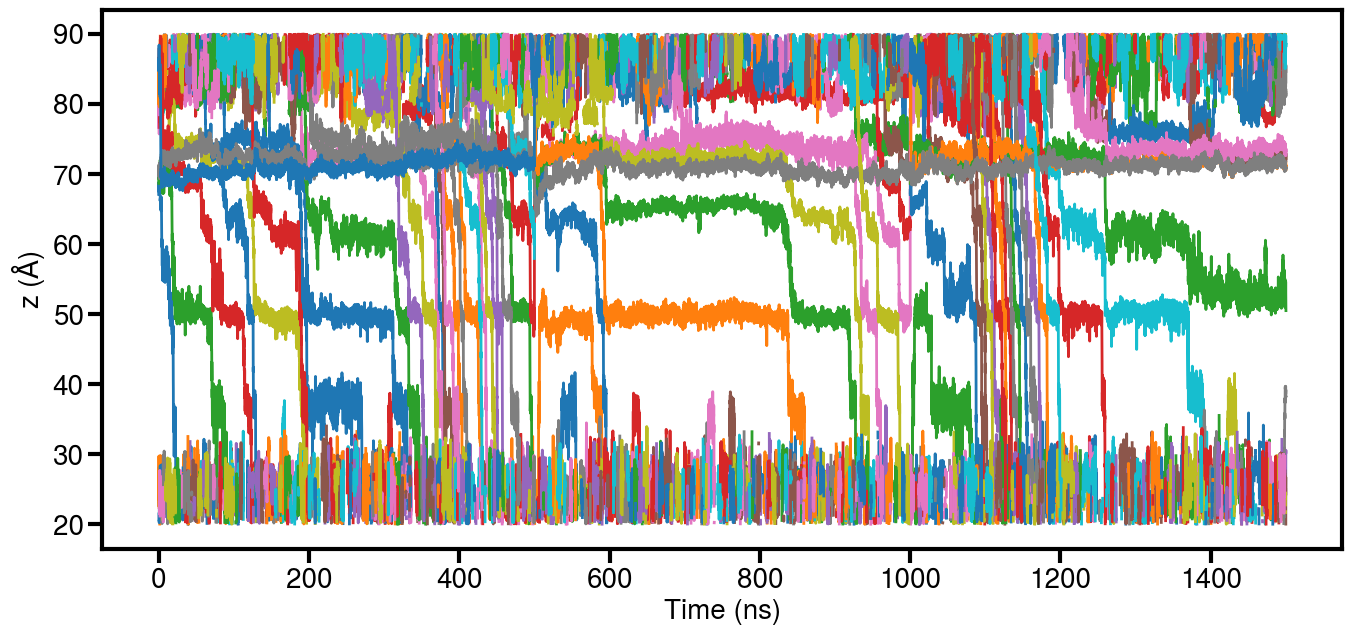

In [6]:

# select ions around SF
prot = u.select_atoms("protein")
print("protein COM: ", prot.center_of_mass())
center_pos = prot.center_of_mass()[:3]

inds_sel = []
for i in range(pos_mgs.shape[0]):
    arr = pos_mgs[i,:,2].copy()
    arrX = pos_mgs[i,:,0].copy()
    arrY = pos_mgs[i,:,1].copy()
    inds = np.where((arr>50) & (arr<75) & ((arrX-center_pos[0])**2+(arrY-center_pos[1])**2<5**2) )[0]
    if len(inds)>10:
        inds_sel.append(i)

        
fig, axes = plt.subplots(1,1, figsize=(16,7))
linewidth = 2

for i in inds_sel:
    arr = pos_mgs[i,:,2].copy()
    arrX = pos_mgs[i,:,0].copy()
    arrY = pos_mgs[i,:,1].copy()
    inds = np.where((arr<20) | (arr>90) | ((arrX-center_pos[0])**2+(arrY-center_pos[1])**2>20**2) )[0]
    arr[inds] = None
    plt.plot(t_plot,arr ,linewidth = linewidth)
plt.xlabel('Time (ns)')
plt.ylabel(r'z ($\rm \AA$)')
# plt.title(r'Trajectory of Ca$^{2\!+}$ in $\rm Ca_V$1.2Apo')
#plt.ylim([60,67])
#plt.xlim([500,503])

ax = plt.gca()
width = 3
ax.spines["top"].set_linewidth(width)
ax.spines["right"].set_linewidth(width)
ax.spines["bottom"].set_linewidth(width)
ax.spines["left"].set_linewidth(width)
plt.tick_params(width=3,length = 10)




In [42]:
# calculate conductance
# Count permeation times by Zhang
import re, sys


sel_heads = "resname POPC and name P"  # DIY
sel_ions = "name "+ ionName                  # DIY


timestep = t_frame # ns
totaltime = t_total # ns

#Define the passing region
u.trajectory[0]    #initilization
memb = u.select_atoms(sel_heads)
zavg = np.average([atom.position[2] for atom in memb])
zup = np.average([atom.position[2] for atom in memb if atom.position[2]>zavg]) - 0.0  # DIY
zup = 60
zdn = np.average([atom.position[2] for atom in memb if atom.position[2]<zavg]) + 0.0  # DIY
zdn = 40

ions = u.select_atoms(sel_ions)
nions = len(ions)
loc_ions = ['']*nions

for ts in u.trajectory:
    j = 0
    for i in ions:
        z = i.position[2]
        if z > zup:
            loc_ions[j] += 'U'
        elif z < zdn:
            loc_ions[j] += 'D'
        else:
            loc_ions[j] += 'M'
        j += 1

npass = 0
j = 0
duration_list = []  # calculate the time distribution of duration
permeate_ions_list = []
per_tstart_list = []
per_tend_list = []
for i in ions:
    for m in re.finditer(r"UM+D", loc_ions[j]): # only count the ions from upside to the downside.
        print('ion[%4s %6d %4s %6d]: %8d - %8d, duration: %.2f ns' % (i.resname, i.resnum, i.name, i.index, m.start(), m.end(), (m.end()-m.start())*timestep))
        npass += 1
        duration_list.append((m.end()-m.start())*timestep)
        permeate_ions_list.append(i.index)
        per_tstart_list.append(m.start())
        per_tend_list.append(m.end())
    j += 1
print("Total passes: %d" % (npass))
print( "Total time  : %.2f ns" % (totaltime))

# calculate the nIonPermeation -t 
# using end time list as permeation time
nPermeationArr = np.zeros(Nt)
for t in range(Nt):
    if t in per_tend_list:
        nPermeationArr[t:] += 1


ion[ CAM    651   D0  19152]:     9306 -     9459, duration: 6.12 ns
ion[ CAM    653   D0  19166]:    10186 -    10640, duration: 18.16 ns
ion[ CAM    654   D0  19173]:    28428 -    28642, duration: 8.56 ns
ion[ CAM    657   D0  19194]:    28165 -    28343, duration: 7.12 ns
ion[ CAM    658   D0  19201]:    27713 -    27803, duration: 3.60 ns
ion[ CAM    661   D0  19222]:    27202 -    27378, duration: 7.04 ns
ion[ CAM    663   D0  19236]:     9207 -     9313, duration: 4.24 ns
ion[ CAM    663   D0  19236]:    10731 -    10887, duration: 6.24 ns
ion[ CAM    665   D0  19250]:    10024 -    10141, duration: 4.68 ns
ion[ CAM    665   D0  19250]:    28341 -    28430, duration: 3.56 ns
ion[ CAM    666   D0  19257]:    27499 -    27726, duration: 9.08 ns
ion[ CAM    667   D0  19264]:    31433 -    34248, duration: 112.60 ns
ion[ CAM    670   D0  19285]:     4751 -     4932, duration: 7.24 ns
ion[ CAM    670   D0  19285]:    28644 -    28856, duration: 8.48 ns
ion[ CAM    672   D0  19299]:  

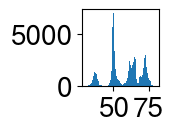

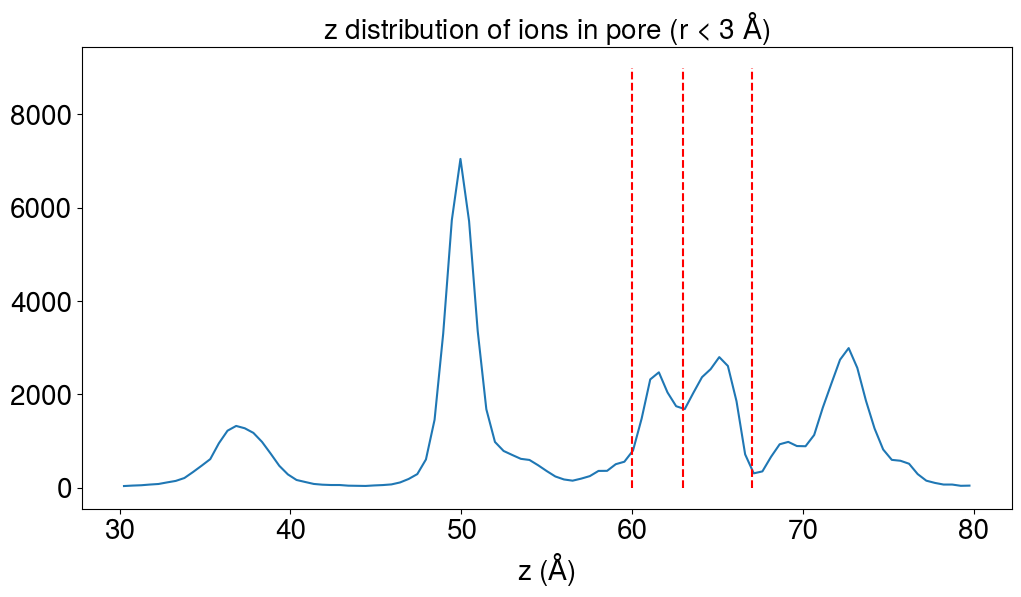

In [7]:
# distribution of z values
# center: ?, radius 3 A
r_cut = 3
# calculate center position
u.trajectory[-1]
prot = u.select_atoms("protein")
center_pos = np.array(prot.center_of_mass()[0:2])

zvals_1 = []
for i in range(len(mgs)):
    data = pos_mgs
    arr = data[i,:,2].copy()
    xArr = data[i,:,0].copy()
    yArr = data[i,:,1].copy()
    rArr = ((xArr-center_pos[0])**2+(yArr-center_pos[1])**2)**0.5
    inds = np.where((arr>25) & (arr<80) & (rArr<r_cut))[0]
    zvals_1.extend(list(arr[inds]))
    

# plot 
histx = []
histy = []
fig, axes = plt.subplots(1,1, figsize=(1,1))
a = plt.hist(zvals_1,bins = list(np.linspace(30,80,100)))
histx.append((a[1][1:]+a[1][:-1])/2)
histy.append(a[0])

fig, axes = plt.subplots(1,1, figsize=(12,6))
for histi in range(1):
    plt.plot(histx[histi],histy[histi])
#plt.legend(["Ca","Na"])
plt.title(r"z distribution of ions in pore (r < 3 $\rm \AA$)")
plt.xlabel(r'z ($\rm \AA$)')
plt.vlines(60,0,9000,color = "red", linestyle="dashed")
plt.vlines(63,0,9000,color = "red", linestyle="dashed")
plt.vlines(67,0,9000,color = "red", linestyle="dashed")

In [14]:
# calculate number of ions in 60~63 and 63~67 respectively in all frames

numArr = np.zeros((Nt,2))  # S2a, S2b

for i in inds_sel:
    arr = pos_mgs[i,:,2].copy()
    arrX = pos_mgs[i,:,0].copy()
    arrY = pos_mgs[i,:,1].copy()
    inds = np.where((arr<20) | (arr>90) | ((arrX-center_pos[0])**2+(arrY-center_pos[1])**2>20**2) )[0]
    
    inds1 = np.where((arr>60)&(arr<63)& ((arrX-center_pos[0])**2+(arrY-center_pos[1])**2<20**2))[0]
    inds2 = np.where((arr>63)&(arr<67)& ((arrX-center_pos[0])**2+(arrY-center_pos[1])**2<20**2))[0]
    numArr[inds1,0] +=1
    numArr[inds2,1] +=1
    
# proportion of states
print("S2d:",len(np.where(numArr[:,0]==1)[0])/Nt)
print("S2u:",len(np.where(numArr[:,1]==1)[0])/Nt)
print("S2d&S2u:",len(np.where((numArr[:,0]==1)&(numArr[:,1]==1))[0])/Nt)

S2d: 0.29792283284003945
S2u: 0.4346318961149775
S2d&S2u: 2.6664533503986347e-05


In [22]:
# investigate the side chain motion of protein, and show the correlation with permeation rates

# investigate DDDD locus (residue 225, 517, 809, 1101)
res_inds = [225, 517, 809, 1101]
# side chain motion of ASP: motion of CG
cgs = u.atoms.residues[res_inds].atoms.select_atoms("name CG")
pos_cgs = u.trajectory.timeseries(asel=cgs)



In [28]:
# calculate cross-distance in x-y plane
# A-C, B-D
dist1 = np.linalg.norm(pos_cgs[0,:,:2]-pos_cgs[2,:,:2],axis = 1)
dist2 = np.linalg.norm(pos_cgs[1,:,:2]-pos_cgs[3,:,:2],axis = 1)


In [71]:
# smooth data
# input: data, box_pts
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

dist1Sm = smooth(dist1,box_pts=10)
dist2Sm = smooth(dist2,box_pts=10)


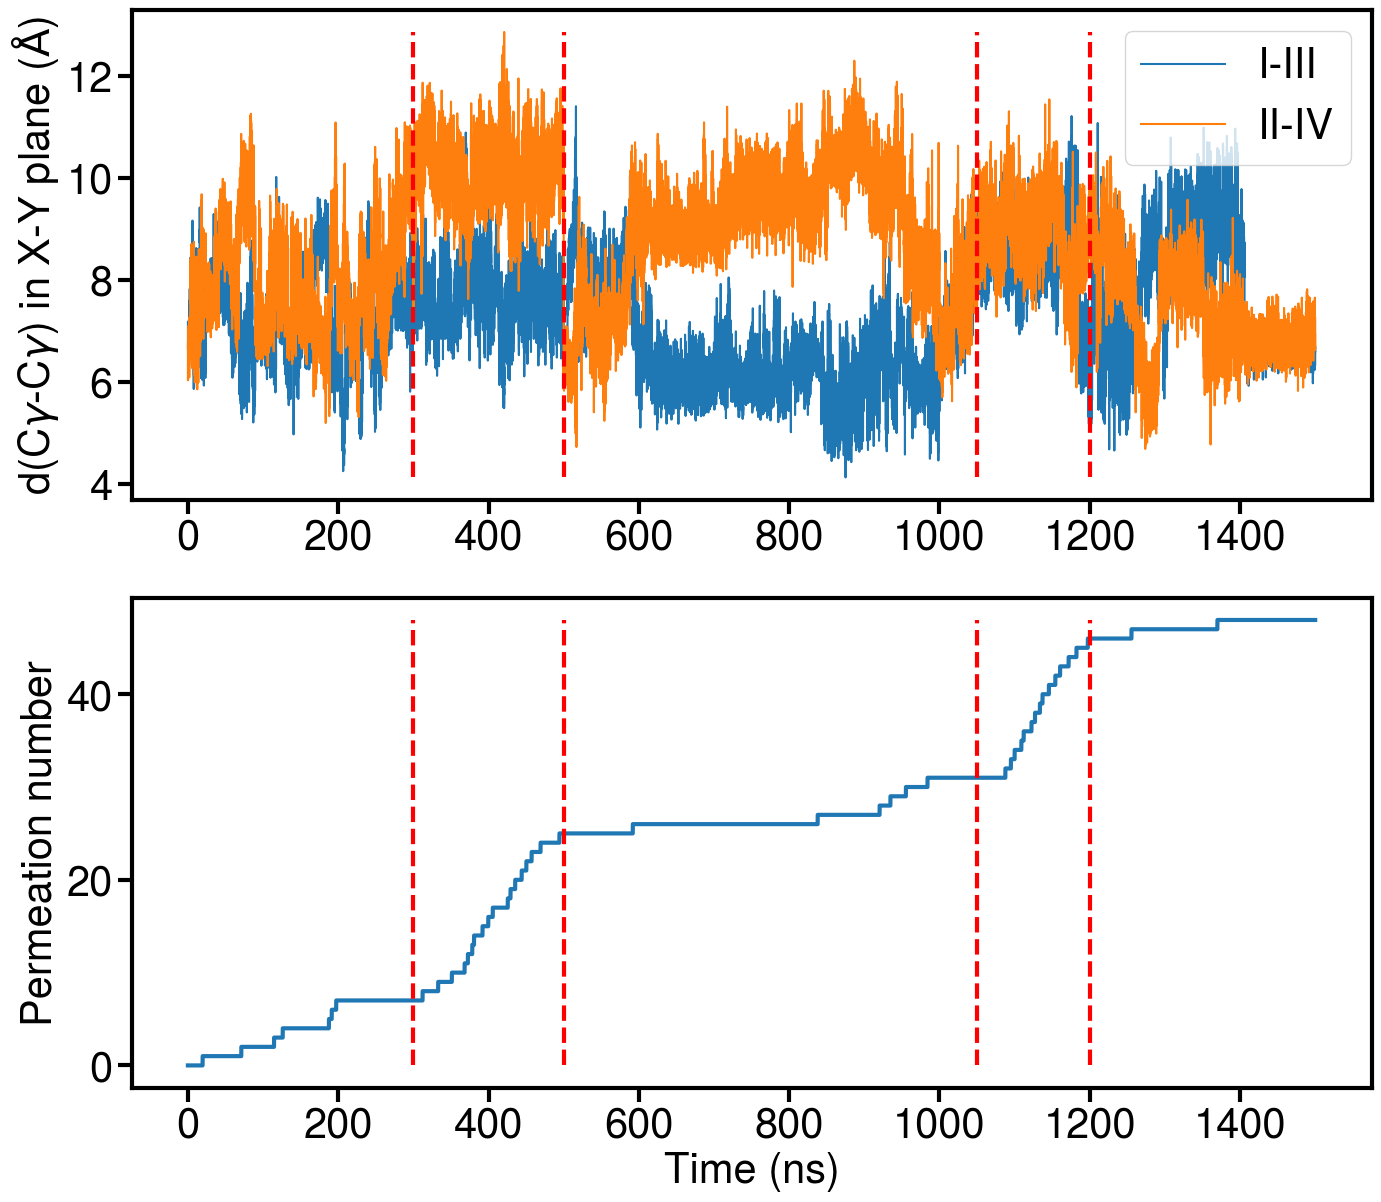

In [96]:
fig, axes = plt.subplots(2,1, figsize=(16,14))
plt.subplot(2,1,1)
arr = pos_cgs[0,:,1]
linewidth = 1.5
#plt.plot(t_plot,distMin ,linewidth = linewidth)
plt.plot(t_plot,dist1 ,linewidth = linewidth)
plt.plot(t_plot,dist2 ,linewidth = linewidth)
#plt.plot(t_plot,dist2 ,linewidth = linewidth)
plt.ylabel(r'd(C$\gamma$-C$\gamma$) in X-Y plane ($\rm \AA$)')
plt.legend(["I-III","II-IV"])

max_val = max(np.concatenate((dist1,dist2)))
linewidth = 3
plt.vlines(300,min(distMin),max_val,color = "red", linestyle="dashed",linewidth = linewidth)
plt.vlines(500,min(distMin),max_val,color = "red", linestyle="dashed",linewidth = linewidth)
plt.vlines(1050,min(distMin),max_val,color = "red", linestyle="dashed",linewidth = linewidth)
plt.vlines(1200,min(distMin),max_val,color = "red", linestyle="dashed",linewidth = linewidth)


ax = plt.gca()
width = 3
ax.spines["top"].set_linewidth(width)
ax.spines["right"].set_linewidth(width)
ax.spines["bottom"].set_linewidth(width)
ax.spines["left"].set_linewidth(width)
plt.tick_params(width=3,length = 10)


# quantify the frequenecy of permeation events
plt.subplot(2,1,2)

plt.plot(t_plot,nPermeationArr,linewidth = linewidth)
plt.vlines(300,min(nPermeationArr),max(nPermeationArr),color = "red", linestyle="dashed",linewidth = linewidth)
plt.vlines(500,min(nPermeationArr),max(nPermeationArr),color = "red", linestyle="dashed",linewidth = linewidth)
plt.vlines(1050,min(nPermeationArr),max(nPermeationArr),color = "red", linestyle="dashed",linewidth = linewidth)
plt.vlines(1200,min(nPermeationArr),max(nPermeationArr),color = "red", linestyle="dashed",linewidth = linewidth)
plt.xlabel('Time (ns)')
plt.ylabel(r'Permeation number')


ax = plt.gca()
width = 3
ax.spines["top"].set_linewidth(width)
ax.spines["right"].set_linewidth(width)
ax.spines["bottom"].set_linewidth(width)
ax.spines["left"].set_linewidth(width)
plt.tick_params(width=3,length = 10)